In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys
import json
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.utils import shuffle

## Read Data

In [2]:
object_akp = pd.read_csv("./data/dbpedia-2016-10/dbp2016-10_object_akp.txt", sep=";", names=["subject","predicate","object","frequency"])
datatype_akp = pd.read_csv("./data/dbpedia-2016-10/dbp2016-10_datatype_akp.txt", sep=";", names=["subject","predicate","object","frequency"])
#object_inst = pd.read_csv("./data/dbpedia-2016-10/dbp2016-10_object_patterns.txt", sep=";", names=["subject","predicate","object","instances"])
#datatype_inst= pd.read_csv("./data/dbpedia-2016-10/dbp2016-10_datatype_patterns.txt", sep=";", names=["subject","predicate","object","instances"])
akps = object_akp.append(datatype_akp)
#patterns = object_inst.append(datatype_inst)

## Data Analysis

#### questioni aperte:
- tenere gli outliers nella frequency? ci sono milioni di pattern con freq=1
- questa rappresentazione normalizzando le statistiche in probabilità fa perdere la magnitudo di frequenze enormi rispetto a quelle insignificanti. Ad esempio, due predicati che hanno frequenze [1,2,5] e [10000,20000,50000] per le medesime 3 coppie hanno lo stesso vettore.
- se cambio ordine "base" delle componenti (ordine nella lista predicati) si mantengono le distanze dei vettori?

#### Riduzione dimensionalità:
- pattern con frequenza 1 --> un predicato viene raramente usato in combinarion con  un pair
- predicati con un solo pattern -->   sono predicati che sono sempre correlati agli stessi subj e obj
- predicati con un solo pattern con frequenza 1 -->  predicati sempre correlati agli stessi subj e obj e che non vengono usati mai
- tipi che compaiono poco? --> 
- pairs che compaiono poco? --> pairs (dimensioni) poco informativi
- predicati la cui frequenza totale è molto bassa --> predicati di cui si hanno pochissime informazioni

<AxesSubplot:>

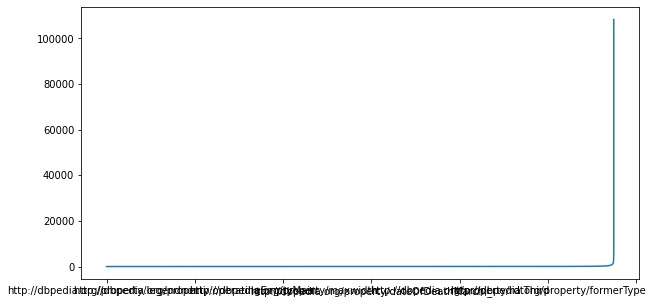

In [7]:
# distribution of properties in the pattern set
plt.rcParams["figure.figsize"] = (10,5)
akps["predicate"].value_counts().sort_values().plot()

In [3]:
def summary(profile):
    # pattern con frequenza 1
    t_2 = akps[akps["frequency"]<2]

    # predicati con un solo pattern
    t_3 = akps.groupby("predicate").size().to_frame("size").reset_index()
    t_3 =t_3[t_3["size"]<2]

    # pattern con frequenza=1 e 1 pattern
    t_4 = t_2.groupby("predicate").size().to_frame("size").reset_index()
    t_4 = t_4[t_4["size"]<2]

    # pairs che compaiono 1 sola volta
    t_5 = akps.groupby(["subject", "object"]).size().to_frame("size").reset_index()
    t_5 = t_5[t_5["size"]<2]
    
    predicates = akps["predicate"].drop_duplicates().tolist()
    # patterns con frequenza = 1
    print('{}: patterns in totale'.format(akps.shape[0]))
    print(' {}: patterns con freq 1'.format(t_2.shape[0]))
    print()
    print('  {}: predicati nel dataset'.format( len(predicates)))
    print('  {}: predicati con un solo pattern'.format(t_3.shape[0]))
    print()
    print('   {}: predicati con un solo pattern e che hanno freq 1'.format(t_4.shape[0]))
    print('  {}: pairs che non si ripetono nel profilo'.format(t_5.shape[0]))
    
    return(t_2, t_3, t_4, t_5)

In [4]:
t_2, t_3, t_4, t_5 = summary(akps)

1636629: patterns in totale
 565657: patterns con freq 1

  57452: predicati nel dataset
  10648: predicati con un solo pattern

   9434: predicati con un solo pattern e che hanno freq 1
  68678: pairs che non si ripetono nel profilo


## Vale la pena rimuovere i pattern con freq=1?

dei pattern con frequenza 1, prendi i predicati e analizza quanti sono i loro pattern prima e dopo aver rimosso i
pattern con freq=1, se la differenza è poca non stiamo togliendo tanta info.
analogamente, controlla quanto è la somma delle freq per quei pattern prima e dopo aver rimosso i pattern con freq=1

In [5]:
# predicati dei pattern con freq=1 --> numero di pattern per ognuno di questi predicati 
# PRIMA DELLA RIMOZIONE
t_preds = t_2['predicate'].to_list()        # predicati coinvolti nei pattern con freq=1
t_n = akps[akps["predicate"].isin(t_preds)]
t_n = t_n.groupby("predicate").size().to_frame("size").reset_index()
t_n.columns = ["predicate", "size_before"]

# DOPO LA RIMOZIONE
t_preds = t_2['predicate'].drop_duplicates().to_list()
t_n2 = akps[akps["frequency"]>1]               # stai tenendo i pattern con freq>1
t_n2 = t_n2[t_n2["predicate"].isin(t_preds)]
t_n2 = t_n2.groupby("predicate").size().to_frame("size").reset_index()
t_n2.columns = ["predicate", "size_after"]

In [6]:
# predicati dei pattern con freq=1 --> somma della freq pattern per ognuno di questi predicati
t_m = akps[akps["predicate"].isin(t_preds)]
t_m = t_m.groupby("predicate")["frequency"].sum().reset_index()
t_m.columns = ["predicate", "sum_before"]

# DOPO LA RIMOZIONE
t_m2 = akps[akps["frequency"]>1]               # stai tenendo i pattern con freq>1
t_m2 = t_m2[t_m2["predicate"].isin(t_preds)]
t_m2 = t_m2.groupby("predicate")["frequency"].sum().reset_index()
t_m2.columns = ["predicate", "sum_after"]

In [7]:
# MERGE dei dati appena ricavati
ciao = pd.merge(t_m, t_m2, how="left", on="predicate")
ciao = pd.merge(ciao, t_n, how="left", on="predicate")
ciao = pd.merge(ciao, t_n2, how="left", on="predicate")
ciao = ciao.fillna(0)

# Creazione di campi per il confronto 
ciao["size_delta"] = ciao["size_before"]-ciao["size_after"]
ciao["sum_delta"] = ciao["sum_before"]-ciao["sum_after"]
ciao["size_delta_%"] = (ciao["size_delta"]*100)/ciao["size_before"]
ciao["sum_delta_%"] = (ciao["sum_delta"]*100)/ciao["sum_before"]

print(t_n.shape)
print(t_n2.shape)
print(t_m.shape)
print(t_m2.shape)
print(ciao.shape)

(43883, 2)
(21635, 2)
(43883, 2)
(21635, 2)
(43883, 9)


In [8]:
ciao.head()

,predicate,sum_before,sum_after,size_before,size_after,size_delta,sum_delta,size_delta_%,sum_delta_%
0,http://dbpedia.org/ontology/Canal/maximumBoatBeam,417,416.0,7,6.0,1.0,1.0,14.285714,0.239808
1,http://dbpedia.org/ontology/Canal/maximumBoatL...,411,410.0,7,6.0,1.0,1.0,14.285714,0.243309
2,http://dbpedia.org/ontology/Canal/originalMaxi...,36,35.0,6,5.0,1.0,1.0,16.666667,2.777778
3,http://dbpedia.org/ontology/Infrastructure/length,68958,68957.0,12,11.0,1.0,1.0,8.333333,0.001450
4,http://dbpedia.org/ontology/MeanOfTransportati...,35245,35244.0,7,6.0,1.0,1.0,14.285714,0.002837


<AxesSubplot:>

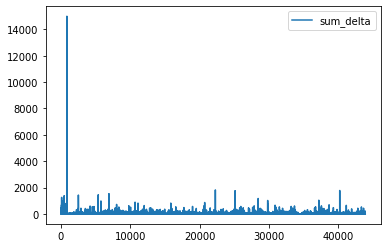

In [9]:
# calo in termini assoluti delle frequenza totale dei pattern associati ai predicati 
# --> si perdono tanti punti frequenza..ma vediamo in dettaglio
ciao[["sum_delta"]].plot()

array([[<AxesSubplot:title={'center':'sum_delta_%'}>]], dtype=object)

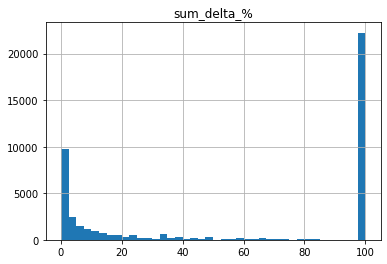

In [10]:
# calo % della frequenza totale dei pattern associati ai predicati: 
# --> prevale una perdita del >90% o <10%
ciao[["sum_delta_%"]].hist(bins=40)
# mostra i predciati per questi casi estremi

array([[<AxesSubplot:title={'center':'size_delta_%'}>]], dtype=object)

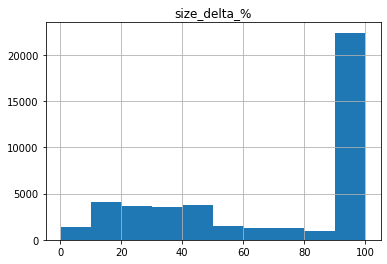

In [11]:
# calo % dei pattern associati ai predicati: 
# --> prevale una perdita del >90%
ciao[["size_delta_%"]].hist()

<AxesSubplot:xlabel='sum_delta', ylabel='sum_delta_%'>

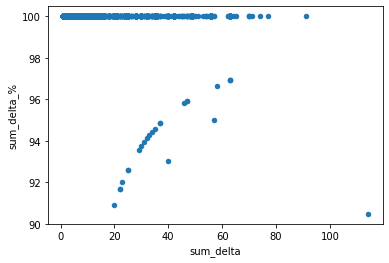

In [12]:
# quando un predicato perde freqeunze > 90% in generale si tratta di valori non oltre i 60 punti 
# --> perdere il 90% di frequenza totale per un predicato è tanto, ma se si parla di 60 triple che lo usano
#     allora forse non è un predicato così imoprtante
ciao[ciao["sum_delta_%"]>90].plot.scatter(x="sum_delta", y="sum_delta_%")

<AxesSubplot:xlabel='sum_delta', ylabel='sum_delta_%'>

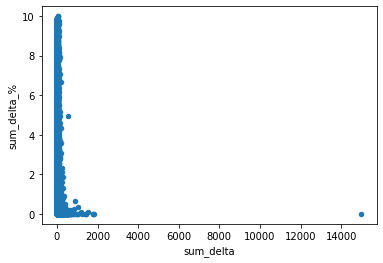

In [13]:
# quando un predicato perde freqeunze < 10% in generale si tratta di valori sotto i 500 punti
# --> 500 e più punti sono tante triple..tuttavia è solo un 10% dei punti frequenza persi
ciao[ciao["sum_delta_%"]<10].plot.scatter(x="sum_delta", y="sum_delta_%")

In [14]:
# quanti sono dbpedia property?
count = 0
for pred in t_preds:
    if "dbpedia.org/property" in pred:
        count += 1
print("predicati toccati : {} ".format(len(t_preds)))
print("di questi sono dbpedia/property: {} ({}%)".format(count, count*100/len(t_preds) ))

predicati toccati : 43883 
di questi sono dbpedia/property: 42988 (97.9604858373402%)


## Preprocessing

In [15]:
akps["pair"]= akps["subject"]+"#-#"+akps["object"]

In [16]:
# Cleaning di pattern con predicati inerenti a wikipedia
akps = akps[~(akps.predicate.str.contains("wiki", case=False))]

#Cleaning dei pairs che non si ripetono
t_5["pair"]= t_5["subject"]+"#-#"+t_5["object"]
akps = akps[~akps["pair"].isin(t_5["pair"].to_list())]
# --> manuelito dice che possiamo togliere questo sopra

# Cleaning dei pattern con freq==1
akps = akps[akps["frequency"]>10] 

#Cleaning predicati con un solo pattern e che hanno freq=1
akps = akps[~akps["predicate"].isin(t_4["predicate"])]

In [17]:
s = summary(akps)

440506: patterns in totale
 0: patterns con freq 1

  17898: predicati nel dataset
  4471: predicati con un solo pattern

   0: predicati con un solo pattern e che hanno freq 1
  4990: pairs che non si ripetono nel profilo


## Freq to Probs

In [18]:
# add a new column "sum": for each predicate it contains the sum of associated frequencies
somma = akps.groupby(by=["predicate"]).agg({'frequency': ['sum']})
somma.columns=["tot"]
akps = pd.merge(akps, somma, how="inner", on="predicate")

In [19]:
# calculate predicate probability for each pair <subject,object>
akps['prob'] = akps.apply(lambda row: ((row.frequency * 100)/row.tot)*0.01, axis=1)

In [48]:
akps.sort_values("predicate")

,subject,predicate,object,frequency,pair,tot,prob
395745,http://xmlns.com/foaf/0.1/Person,http://dbpedia.org/ontology/Astronaut/timeInSpace,http://dbpedia.org/datatype/minute,531,http://xmlns.com/foaf/0.1/Person#-#http://dbpe...,3186,0.166667
395741,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/ontology/Astronaut/timeInSpace,http://dbpedia.org/datatype/minute,531,http://www.ontologydesignpatterns.org/ont/dul/...,3186,0.166667
395742,http://wikidata.dbpedia.org/resource/Q215627,http://dbpedia.org/ontology/Astronaut/timeInSpace,http://dbpedia.org/datatype/minute,531,http://wikidata.dbpedia.org/resource/Q215627#-...,3186,0.166667
395743,http://wikidata.dbpedia.org/resource/Q5,http://dbpedia.org/ontology/Astronaut/timeInSpace,http://dbpedia.org/datatype/minute,531,http://wikidata.dbpedia.org/resource/Q5#-#http...,3186,0.166667
395744,http://schema.org/Person,http://dbpedia.org/ontology/Astronaut/timeInSpace,http://dbpedia.org/datatype/minute,531,http://schema.org/Person#-#http://dbpedia.org/...,3186,0.166667
...,...,...,...,...,...,...,...
370099,http://dbpedia.org/ontology/Building,http://xmlns.com/foaf/0.1/surname,http://www.w3.org/2000/01/rdf-schema#Literal,11,http://dbpedia.org/ontology/Building#-#http://...,7329719,0.000002
370098,http://dbpedia.org/ontology/Wrestler,http://xmlns.com/foaf/0.1/surname,http://www.w3.org/2000/01/rdf-schema#Literal,2814,http://dbpedia.org/ontology/Wrestler#-#http://...,7329719,0.000384
370103,http://schema.org/Place,http://xmlns.com/foaf/0.1/surname,http://www.w3.org/2000/01/rdf-schema#Literal,28,http://schema.org/Place#-#http://www.w3.org/20...,7329719,0.000004
370014,http://dbpedia.org/ontology/Swimmer,http://xmlns.com/foaf/0.1/surname,http://www.w3.org/2000/01/rdf-schema#Literal,3582,http://dbpedia.org/ontology/Swimmer#-#http://w...,7329719,0.000489


## Property Space

In [21]:
# obtain the dimensions of the property space
dimensions = akps[["pair"]].drop_duplicates().reset_index(drop="True")
dimensions["component"]=dimensions.index
dimensions.columns = ["component_label","component"]
dimensions

,component_label,component
0,http://schema.org/Organization#-#http://www.w3...,0
1,http://dbpedia.org/ontology/Wikidata:Q532#-#ht...,1
2,http://www.opengis.net/gml/_Feature#-#http://w...,2
3,http://dbpedia.org/ontology/Castle#-#http://ww...,3
4,http://dbpedia.org/ontology/Valley#-#http://ww...,4
...,...,...
24711,http://dbpedia.org/ontology/Grape#-#http://www...,24711
24712,http://dbpedia.org/ontology/Planet#-#http://db...,24712
24713,http://dbpedia.org/ontology/Planet#-#http://db...,24713
24714,http://dbpedia.org/ontology/Sales#-#http://www...,24714


In [22]:
def vectorize(temp):
    vec = np.zeros(dimensions.shape[0])
    for comp in temp["component"]:
        val = temp[temp["component"]==comp]["prob"].iloc[0]
        vec[comp]=val
    return(vec)

In [55]:
count=0
space_df = pd.DataFrame()
predicates = akps["predicate"].drop_duplicates().tolist()
for pred in predicates:
#for pred in [ "http://dbpedia.org/ontology/name", "http://dbpedia.org/ontology/birthPlace"]:
    count += 1
    df_pred = akps.loc[akps["predicate"] == pred, ["pair", "prob"]]
    notzero_subset = dimensions[dimensions["component_label"].isin(df_pred["pair"])]
    temp = pd.merge(df_pred, notzero_subset, how="inner", left_on='pair', right_on='component_label').drop(columns=["pair","component_label"])
   
    vec = vectorize(temp)
    space_df[pred]=vec
    if(count%100==0):
        print(count)

100


/tmp/ipykernel_6541/3468284293.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  space_df[pred]=vec


200
300


KeyboardInterrupt: 

In [3]:
#space_df.to_pickle("space.pickle") 
space_df = pd.read_pickle("TRANSPOSED_full-clean_>10-freq.pickle")

In [4]:
space_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,24706,24707,24708,24709,24710,24711,24712,24713,24714,24715
http://xmlns.com/foaf/0.1/homepage,0.070163,0.046409,0.042534,0.000041,0.000004,0.000294,0.000142,0.000019,0.000023,0.000010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.w3.org/2002/07/owl#sameAs,0.011569,0.059918,0.043439,0.000063,0.000005,0.000097,0.000730,0.000094,0.000011,0.000148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://xmlns.com/foaf/0.1/depiction,0.016497,0.073506,0.048459,0.000173,0.000022,0.000364,0.000628,0.000116,0.000003,0.000058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://dbpedia.org/ontology/thumbnail,0.016495,0.073519,0.048468,0.000173,0.000022,0.000364,0.000628,0.000116,0.000003,0.000058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://dbpedia.org/ontology/currentMember,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity

In [5]:
space_df.index.to_list()
for el in space_df.index.to_list():
    if "dbpedia.org/ontology" in el:
        print(el)

http://dbpedia.org/ontology/thumbnail
http://dbpedia.org/ontology/currentMember
http://dbpedia.org/ontology/managerClub
http://dbpedia.org/ontology/location
http://dbpedia.org/ontology/club
http://dbpedia.org/ontology/leftTributary
http://dbpedia.org/ontology/team
http://dbpedia.org/ontology/militaryUnit
http://dbpedia.org/ontology/producer
http://dbpedia.org/ontology/followingEvent
http://dbpedia.org/ontology/firstRace
http://dbpedia.org/ontology/commandStructure
http://dbpedia.org/ontology/associatedMusicalArtist
http://dbpedia.org/ontology/recordLabel
http://dbpedia.org/ontology/writer
http://dbpedia.org/ontology/birthPlace
http://dbpedia.org/ontology/subsequentWork
http://dbpedia.org/ontology/previousWork
http://dbpedia.org/ontology/musicComposer
http://dbpedia.org/ontology/illustrator
http://dbpedia.org/ontology/primeMinister
http://dbpedia.org/ontology/successor
http://dbpedia.org/ontology/relative
http://dbpedia.org/ontology/highschool
http://dbpedia.org/ontology/monarch
http://

In [6]:
# return euclidean and cosine similarity betweem two vectors
def similarity(vec1, vec2):
    euclidean = distance.euclidean(vec1, vec2)
    cosine = distance.cosine(vec1, vec2)
    return(euclidean, cosine)

# return a dataframe with euclidean and cosine similarity betweem prop and the first n samples in sapce_df
def similarities(space_df, prop, n):
    count=0
    distance_df= pd.DataFrame(columns=["euclidean","cosine"])
    a_vector = space_df.loc[[prop],].iloc[0].to_list()
    for index in space_df.index.to_list():                    # itera sui predicati
        b_vector = space_df.loc[[index],].iloc[0].to_list()
        euclidean, cosine = similarity(a_vector,b_vector)
        distance_df.loc[index] = [euclidean, cosine]
        count +=1
        if(count>n):
            break
    return(distance_df)

# print the most similar properties for a given prop over the first n samples in space_df
def find_similar_props(space_df, prop, n):
    distance_df = similarities(space_df, prop, n)
    display(distance_df.sort_values("euclidean").head(10))
    #display(distance_df.sort_values("euclidean", ascending=False).head(10))
    display(distance_df.sort_values("cosine").head(10))
    #display(distance_df.sort_values("cosine", ascending=False).head(10))
    #return(distance_df)

In [60]:
find_similar_props(space_df, "http://dbpedia.org/ontology/team", 14000)

,euclidean,cosine
http://dbpedia.org/ontology/team,0.000000,0.000000
http://dbpedia.org/property/clubs,0.022486,0.011533
http://dbpedia.org/property/nationalteam,0.023225,0.011437
http://dbpedia.org/property/currentclub,0.023874,0.012227
http://dbpedia.org/property/youthclubs,0.029538,0.019962
http://dbpedia.org/property/majorclubs,0.058686,0.040840
http://dbpedia.org/property/youthteams,0.058692,0.040641
http://dbpedia.org/property/managerclubs,0.064569,0.093493
http://dbpedia.org/ontology/managerClub,0.064927,0.092866
http://dbpedia.org/property/draftTeamPba,0.074268,0.122110


,euclidean,cosine
http://dbpedia.org/ontology/team,0.000000,0.000000
http://dbpedia.org/property/nationalteam,0.023225,0.011437
http://dbpedia.org/property/clubs,0.022486,0.011533
http://dbpedia.org/property/currentclub,0.023874,0.012227
http://dbpedia.org/property/youthclubs,0.029538,0.019962
http://dbpedia.org/property/youthteams,0.058692,0.040641
http://dbpedia.org/property/majorclubs,0.058686,0.040840
http://dbpedia.org/ontology/managerClub,0.064927,0.092866
http://dbpedia.org/property/managerclubs,0.064569,0.093493
http://dbpedia.org/property/draftTeamPba,0.074268,0.122110


In [84]:
find_similar_props(space_df, "http://dbpedia.org/ontology/president", 14000)

,euclidean,cosine
http://dbpedia.org/ontology/president,0.000000,0.000000
http://dbpedia.org/property/president,0.027902,0.032777
http://dbpedia.org/ontology/appointer,0.030962,0.025677
http://dbpedia.org/property/appointer,0.031767,0.039596
http://dbpedia.org/ontology/vicePresident,0.032145,0.031797
http://dbpedia.org/property/primeminister,0.034221,0.030138
http://dbpedia.org/property/premier,0.035288,0.029426
http://dbpedia.org/ontology/primeMinister,0.035309,0.029331
http://dbpedia.org/property/governor,0.035877,0.040199
http://dbpedia.org/property/1namedata,0.036088,0.027759


,euclidean,cosine
http://dbpedia.org/ontology/president,0.000000,0.000000
http://dbpedia.org/ontology/appointer,0.030962,0.025677
http://dbpedia.org/property/1namedata,0.036088,0.027759
http://dbpedia.org/ontology/primeMinister,0.035309,0.029331
http://dbpedia.org/property/premier,0.035288,0.029426
http://dbpedia.org/property/primeminister,0.034221,0.030138
http://dbpedia.org/ontology/vicePresident,0.032145,0.031797
http://dbpedia.org/property/president,0.027902,0.032777
http://dbpedia.org/property/firstminister,0.046600,0.037696
http://dbpedia.org/ontology/deputy,0.040141,0.037956


In [81]:
find_similar_props(space_df, "http://dbpedia.org/ontology/spouse", 14000)

,euclidean,cosine
http://dbpedia.org/ontology/spouse,0.000000,0.000000
http://dbpedia.org/ontology/child,0.017710,0.009853
http://dbpedia.org/ontology/relative,0.022062,0.015172
http://dbpedia.org/property/after,0.025268,0.018435
http://dbpedia.org/property/before,0.025491,0.018686
http://dbpedia.org/ontology/partner,0.026065,0.018545
http://dbpedia.org/ontology/parent,0.026447,0.022240
http://dbpedia.org/ontology/relation,0.030494,0.029584
http://dbpedia.org/property/regent,0.031198,0.031176
http://dbpedia.org/ontology/opponent,0.036561,0.042244


,euclidean,cosine
http://dbpedia.org/ontology/spouse,0.000000,0.000000
http://dbpedia.org/ontology/child,0.017710,0.009853
http://dbpedia.org/ontology/relative,0.022062,0.015172
http://dbpedia.org/property/after,0.025268,0.018435
http://dbpedia.org/ontology/partner,0.026065,0.018545
http://dbpedia.org/property/before,0.025491,0.018686
http://dbpedia.org/ontology/parent,0.026447,0.022240
http://dbpedia.org/ontology/relation,0.030494,0.029584
http://dbpedia.org/property/regent,0.031198,0.031176
http://dbpedia.org/property/disciple,0.040928,0.038413


In [80]:
find_similar_props(space_df, "http://dbpedia.org/ontology/birthPlace", 14000)

,euclidean,cosine
http://dbpedia.org/ontology/birthPlace,0.000000,0.000000
http://dbpedia.org/ontology/deathPlace,0.010982,0.004261
http://dbpedia.org/property/birthPlace,0.012902,0.005777
http://dbpedia.org/ontology/residence,0.023125,0.018785
http://dbpedia.org/property/deathPlace,0.024711,0.021575
http://dbpedia.org/property/placeOfBirth,0.026927,0.025865
http://dbpedia.org/property/residence,0.032057,0.037001
http://dbpedia.org/property/homeTown,0.038093,0.050879
http://dbpedia.org/property/placeOfDeath,0.039238,0.055970
http://dbpedia.org/ontology/restingPlace,0.045102,0.069448


,euclidean,cosine
http://dbpedia.org/ontology/birthPlace,0.000000,0.000000
http://dbpedia.org/ontology/deathPlace,0.010982,0.004261
http://dbpedia.org/property/birthPlace,0.012902,0.005777
http://dbpedia.org/ontology/residence,0.023125,0.018785
http://dbpedia.org/property/deathPlace,0.024711,0.021575
http://dbpedia.org/property/placeOfBirth,0.026927,0.025865
http://dbpedia.org/property/residence,0.032057,0.037001
http://dbpedia.org/property/homeTown,0.038093,0.050879
http://dbpedia.org/property/placeOfDeath,0.039238,0.055970
http://dbpedia.org/property/deathplace,0.045760,0.058935


In [79]:
find_similar_props(space_df, "http://dbpedia.org/ontology/school", 14000)

,euclidean,cosine
http://dbpedia.org/ontology/school,0.000000,0.000000
http://dbpedia.org/ontology/highschool,0.050716,0.095962
http://dbpedia.org/property/highschool,0.059604,0.132136
http://dbpedia.org/property/school,0.066841,0.169318
http://dbpedia.org/property/university,0.079946,0.254679
http://dbpedia.org/ontology/education,0.080065,0.236961
http://dbpedia.org/property/highSchool,0.080651,0.243036
http://dbpedia.org/property/yeshiva,0.081106,0.246593
http://dbpedia.org/property/education,0.081468,0.255301
http://dbpedia.org/ontology/university,0.081694,0.256769


,euclidean,cosine
http://dbpedia.org/ontology/school,0.000000,0.000000
http://dbpedia.org/ontology/highschool,0.050716,0.095962
http://dbpedia.org/property/highschool,0.059604,0.132136
http://dbpedia.org/property/school,0.066841,0.169318
http://dbpedia.org/ontology/education,0.080065,0.236961
http://dbpedia.org/property/highSchool,0.080651,0.243036
http://dbpedia.org/property/yeshiva,0.081106,0.246593
http://dbpedia.org/ontology/almaMater,0.084161,0.253983
http://dbpedia.org/property/university,0.079946,0.254679
http://dbpedia.org/property/education,0.081468,0.255301


In [78]:
find_similar_props(space_df, "http://dbpedia.org/property/leader", 14000)

,euclidean,cosine
http://dbpedia.org/property/leader,0.000000,0.000000
http://dbpedia.org/property/elected,0.094953,0.441786
http://dbpedia.org/property/vpName,0.102612,0.239926
http://dbpedia.org/property/chancellor,0.109081,0.624877
http://dbpedia.org/ontology/leader,0.109278,0.486178
http://dbpedia.org/property/bishop,0.112701,0.744479
http://dbpedia.org/ontology/chancellor,0.112938,0.620999
http://dbpedia.org/property/patron,0.114515,0.687400
http://dbpedia.org/property/owner,0.116312,0.828202
http://dbpedia.org/property/president,0.116382,0.681135


,euclidean,cosine
http://dbpedia.org/property/leader,0.000000,0.000000
http://dbpedia.org/ontology/secondLeader,0.142917,0.213940
http://dbpedia.org/ontology/firstLeader,0.143986,0.215480
http://dbpedia.org/property/beforeElection,0.137610,0.216640
http://dbpedia.org/property/afterElection,0.137952,0.216873
http://dbpedia.org/property/nominee,0.131690,0.221051
http://dbpedia.org/property/runningMate,0.133154,0.230228
http://dbpedia.org/property/vpName,0.102612,0.239926
http://dbpedia.org/property/elected,0.094953,0.441786
http://dbpedia.org/ontology/commander,0.151160,0.477779


In [77]:
find_similar_props(space_df, "http://dbpedia.org/property/starring", 14000)

,euclidean,cosine
http://dbpedia.org/property/starring,0.000000,0.000000
http://dbpedia.org/property/director,0.017997,0.004978
http://dbpedia.org/ontology/starring,0.018635,0.005339
http://dbpedia.org/ontology/director,0.023647,0.009598
http://dbpedia.org/property/narrator,0.026841,0.012100
http://dbpedia.org/property/screenwriter,0.035182,0.018621
http://dbpedia.org/ontology/cinematography,0.036505,0.016487
http://dbpedia.org/property/costumes,0.042052,0.023656
http://dbpedia.org/ontology/editing,0.045787,0.033789
http://dbpedia.org/ontology/narrator,0.054201,0.050009


,euclidean,cosine
http://dbpedia.org/property/starring,0.000000,0.000000
http://dbpedia.org/property/director,0.017997,0.004978
http://dbpedia.org/ontology/starring,0.018635,0.005339
http://dbpedia.org/ontology/director,0.023647,0.009598
http://dbpedia.org/property/narrator,0.026841,0.012100
http://dbpedia.org/ontology/cinematography,0.036505,0.016487
http://dbpedia.org/property/screenwriter,0.035182,0.018621
http://dbpedia.org/property/costumes,0.042052,0.023656
http://dbpedia.org/ontology/editing,0.045787,0.033789
http://dbpedia.org/ontology/narrator,0.054201,0.050009


In [76]:
find_similar_props(space_df, "http://dbpedia.org/property/origin", 14000)

,euclidean,cosine
http://dbpedia.org/property/origin,0.000000,0.000000
http://dbpedia.org/ontology/hometown,0.019466,0.010648
http://dbpedia.org/property/placeOfBirth,0.094970,0.346964
http://dbpedia.org/property/birthPlace,0.095047,0.340609
http://dbpedia.org/property/deathPlace,0.095198,0.349883
http://dbpedia.org/ontology/birthPlace,0.096908,0.345740
http://dbpedia.org/property/placeOfDeath,0.097092,0.365457
http://dbpedia.org/property/residence,0.097133,0.363928
http://dbpedia.org/ontology/deathPlace,0.098004,0.353352
http://dbpedia.org/ontology/residence,0.100103,0.366618


,euclidean,cosine
http://dbpedia.org/property/origin,0.000000,0.000000
http://dbpedia.org/ontology/hometown,0.019466,0.010648
http://dbpedia.org/property/currentCity,0.147895,0.336468
http://dbpedia.org/property/birthPlace,0.095047,0.340609
http://dbpedia.org/ontology/birthPlace,0.096908,0.345740
http://dbpedia.org/property/placeOfBirth,0.094970,0.346964
http://dbpedia.org/property/deathPlace,0.095198,0.349883
http://dbpedia.org/ontology/deathPlace,0.098004,0.353352
http://dbpedia.org/property/deathplace,0.106405,0.358740
http://dbpedia.org/property/residence,0.097133,0.363928


In [75]:
find_similar_props(space_df, "http://dbpedia.org/property/foundedBy", 14000)

,euclidean,cosine
http://dbpedia.org/property/foundedBy,0.000000,0.000000
http://dbpedia.org/property/politicalSubdiv,0.144651,0.247231
http://dbpedia.org/property/leaderName,0.152741,0.337312
http://dbpedia.org/property/nation,0.155740,0.317998
http://dbpedia.org/property/etymology,0.161629,0.363823
http://dbpedia.org/property/rulingParty,0.163263,0.366423
http://dbpedia.org/property/leaderTitle,0.165354,0.362167
http://dbpedia.org/property/architect,0.166334,0.411400
http://dbpedia.org/property/fedRep,0.167799,0.397427
http://dbpedia.org/property/management,0.172255,0.455293


,euclidean,cosine
http://dbpedia.org/property/foundedBy,0.000000,0.000000
http://dbpedia.org/property/munFormation,0.266689,0.067091
http://dbpedia.org/property/selsovietType,0.266325,0.067224
http://dbpedia.org/property/imageView,0.268538,0.067513
http://dbpedia.org/property/associationName,0.268578,0.067776
http://dbpedia.org/property/munFormation1LeaderName,0.268587,0.067817
http://dbpedia.org/property/munFormation1LeaderTitle,0.268588,0.067821
http://dbpedia.org/property/townOfDistrictSignificanceType,0.268637,0.067996
http://dbpedia.org/property/areaOfWhat,0.261167,0.070572
http://dbpedia.org/property/skyline,0.250487,0.073511


In [8]:
find_similar_props(space_df, "http://dbpedia.org/ontology/residence", 14000)

,euclidean,cosine
http://dbpedia.org/ontology/residence,0.000000,0.000000
http://dbpedia.org/ontology/deathPlace,0.017920,0.011270
http://dbpedia.org/ontology/birthPlace,0.023125,0.018785
http://dbpedia.org/property/residence,0.023380,0.018848
http://dbpedia.org/property/deathPlace,0.026951,0.025431
http://dbpedia.org/property/birthPlace,0.027462,0.026721
http://dbpedia.org/property/placeOfBirth,0.035758,0.045744
http://dbpedia.org/property/homeTown,0.036907,0.047515
http://dbpedia.org/property/placeOfDeath,0.041430,0.061878
http://dbpedia.org/ontology/restingPlace,0.042991,0.062847


,euclidean,cosine
http://dbpedia.org/ontology/residence,0.000000,0.000000
http://dbpedia.org/ontology/deathPlace,0.017920,0.011270
http://dbpedia.org/ontology/birthPlace,0.023125,0.018785
http://dbpedia.org/property/residence,0.023380,0.018848
http://dbpedia.org/property/deathPlace,0.026951,0.025431
http://dbpedia.org/property/birthPlace,0.027462,0.026721
http://dbpedia.org/property/placeOfBirth,0.035758,0.045744
http://dbpedia.org/property/homeTown,0.036907,0.047515
http://dbpedia.org/property/placeOfDeath,0.041430,0.061878
http://dbpedia.org/ontology/restingPlace,0.042991,0.062847


## PCA

In [90]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(space_df)
pcs_df = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2'])

In [92]:
#pcs_df

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

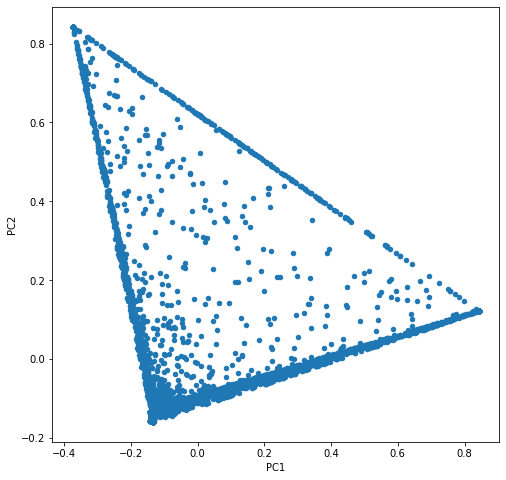

In [95]:
plt.rcParams["figure.figsize"] = (8,8)
pcs_df.plot.scatter(x="PC1", y="PC2")

## Properties Analysis

In [31]:
# select the predicates with n patterns
n = 5
temporal = akps.groupby(["predicate"]).size().to_frame("count").reset_index()
samp_preds = temporal[temporal["count"]==n]["predicate"].to_list()
len(samp_preds)

702

In [32]:
# for each selected predicate retrieve all the associated pairs
diz = dict()
count=0
for predicate in samp_preds:
    count += 1
    pairs_set = set()
    for pair in akps[akps["predicate"]==predicate]["pair"]:
        pairs_set.add(pair)
    diz[predicate]=pairs_set
    if count%100 == 0:
        print(count)

100
200
300
400
500
600
700


In [33]:
# for each prediate find the predicates with exactly the same set of pairs
overlapped_preds = dict()
for key1 in diz.keys():
    overlapping = set()
    for key2 in diz.keys():
        if diz[key1] == diz[key2] and key1 != key2:
            overlapping.add(key2)
    overlapped_preds[key1]=overlapping        

In [38]:
for pred in overlapped_preds.keys():
    print(pred)

http://dbpedia.org/ontology/damsire
http://dbpedia.org/ontology/drainsFrom
http://dbpedia.org/ontology/ecNumber
http://dbpedia.org/ontology/editorTitle
http://dbpedia.org/ontology/failedLaunches
http://dbpedia.org/ontology/firstPublicationDate
http://dbpedia.org/ontology/firstPublicationYear
http://dbpedia.org/ontology/grandsire
http://dbpedia.org/ontology/imageSize
http://dbpedia.org/ontology/impactFactor
http://dbpedia.org/ontology/impactFactorAsOf
http://dbpedia.org/ontology/lastPublicationDate
http://dbpedia.org/ontology/leaderFunction
http://dbpedia.org/ontology/managementElevation
http://dbpedia.org/ontology/mass
http://dbpedia.org/ontology/numberOfPages
http://dbpedia.org/ontology/numberOfVolumes
http://dbpedia.org/ontology/omim
http://dbpedia.org/ontology/partialFailedLaunches
http://dbpedia.org/ontology/reopeningDate
http://dbpedia.org/ontology/rocketFunction
http://dbpedia.org/ontology/shipBeam
http://dbpedia.org/ontology/shipDisplacement
http://dbpedia.org/ontology/successfu

In [84]:
overlapped_preds["http://dbpedia.org/property/originalMembers"]

{'http://dbpedia.org/property/bandMembers',
 'http://dbpedia.org/property/guestMembers',
 'http://dbpedia.org/property/liveMembers',
 'http://dbpedia.org/property/pastMembersRayGunn19811983,Recorded10OfMyOriginalsPlusOurVersionOfDancingInTheStreets,UnfortunatelyThisNeverGotPastTheRoughMixStage,AsTheSameWithMyEffortsInTheNewOrder',
 'http://dbpedia.org/property/presentMembers',
 'http://dbpedia.org/property/selectedCollaborators',
 'http://dbpedia.org/property/touringMembers'}

In [85]:
akps[akps["predicate"]=="http://dbpedia.org/property/originalMembers"]

,subject,predicate,object,frequency,pair,tot,prob
376180,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/originalMembers,http://www.w3.org/2000/01/rdf-schema#Literal,28,http://www.ontologydesignpatterns.org/ont/dul/...,84,0.333333
376181,http://schema.org/Organization,http://dbpedia.org/property/originalMembers,http://www.w3.org/2000/01/rdf-schema#Literal,28,http://schema.org/Organization#-#http://www.w3...,84,0.333333
376182,http://dbpedia.org/ontology/Band,http://dbpedia.org/property/originalMembers,http://www.w3.org/2000/01/rdf-schema#Literal,28,http://dbpedia.org/ontology/Band#-#http://www....,84,0.333333


In [52]:
akps[akps["predicate"]=="http://dbpedia.org/property/liveMembers"]

,subject,predicate,object,frequency,pair,tot,prob
434726,http://schema.org/Organization,http://dbpedia.org/property/liveMembers,http://www.w3.org/2000/01/rdf-schema#Literal,21,http://schema.org/Organization#-#http://www.w3...,63,0.333333
434727,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/liveMembers,http://www.w3.org/2000/01/rdf-schema#Literal,21,http://www.ontologydesignpatterns.org/ont/dul/...,63,0.333333
434728,http://dbpedia.org/ontology/Band,http://dbpedia.org/property/liveMembers,http://www.w3.org/2000/01/rdf-schema#Literal,21,http://dbpedia.org/ontology/Band#-#http://www....,63,0.333333


In [31]:
akps[akps["predicate"]=="http://dbpedia.org/property/touringMembers"]

,subject,predicate,object,frequency,pair,tot,prob
391759,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/touringMembers,http://www.w3.org/2000/01/rdf-schema#Literal,33,http://www.ontologydesignpatterns.org/ont/dul/...,99,0.333333
391760,http://dbpedia.org/ontology/Band,http://dbpedia.org/property/touringMembers,http://www.w3.org/2000/01/rdf-schema#Literal,33,http://dbpedia.org/ontology/Band#-#http://www....,99,0.333333
391761,http://schema.org/Organization,http://dbpedia.org/property/touringMembers,http://www.w3.org/2000/01/rdf-schema#Literal,33,http://schema.org/Organization#-#http://www.w3...,99,0.333333


In [86]:
akps[akps["predicate"]=="http://dbpedia.org/property/bandMembers"]

,subject,predicate,object,frequency,pair,tot,prob
438298,http://schema.org/Organization,http://dbpedia.org/property/bandMembers,http://www.w3.org/2000/01/rdf-schema#Literal,15,http://schema.org/Organization#-#http://www.w3...,48,0.3125
438299,http://dbpedia.org/ontology/Band,http://dbpedia.org/property/bandMembers,http://www.w3.org/2000/01/rdf-schema#Literal,15,http://dbpedia.org/ontology/Band#-#http://www....,48,0.3125
438300,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/bandMembers,http://www.w3.org/2000/01/rdf-schema#Literal,18,http://www.ontologydesignpatterns.org/ont/dul/...,48,0.3750


In [43]:
akps[akps["predicate"]=="http://dbpedia.org/property/currentMembers"]

,subject,predicate,object,frequency,pair,tot,prob
34591,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/currentMembers,http://schema.org/Person,13249,http://www.ontologydesignpatterns.org/ont/dul/...,477448,0.027750
34592,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/currentMembers,http://dbpedia.org/ontology/Comedian,22,http://www.ontologydesignpatterns.org/ont/dul/...,477448,0.000046
34593,http://schema.org/Organization,http://dbpedia.org/property/currentMembers,http://wikidata.dbpedia.org/resource/Q5,13242,http://schema.org/Organization#-#http://wikida...,477448,0.027735
34594,http://xmlns.com/foaf/0.1/Person,http://dbpedia.org/property/currentMembers,http://schema.org/Person,71,http://xmlns.com/foaf/0.1/Person#-#http://sche...,477448,0.000149
34595,http://dbpedia.org/ontology/Band,http://dbpedia.org/property/currentMembers,http://dbpedia.org/ontology/Comedian,17,http://dbpedia.org/ontology/Band#-#http://dbpe...,477448,0.000036
...,...,...,...,...,...,...,...
34706,http://schema.org/Organization,http://dbpedia.org/property/currentMembers,http://www.w3.org/2001/XMLSchema#integer,53,http://schema.org/Organization#-#http://www.w3...,477448,0.000111
34707,http://schema.org/Person,http://dbpedia.org/property/currentMembers,http://www.w3.org/2000/01/rdf-schema#Literal,93,http://schema.org/Person#-#http://www.w3.org/2...,477448,0.000195
34708,http://www.ontologydesignpatterns.org/ont/dul/...,http://dbpedia.org/property/currentMembers,http://www.w3.org/2000/01/rdf-schema#Literal,69,http://www.ontologydesignpatterns.org/ont/dul/...,477448,0.000145
34709,http://schema.org/Organization,http://dbpedia.org/property/currentMembers,http://www.w3.org/2000/01/rdf-schema#Literal,62085,http://schema.org/Organization#-#http://www.w3...,477448,0.130035


In [88]:
similarity(space_df.loc["http://dbpedia.org/property/originalMembers"], space_df.loc["http://dbpedia.org/property/liveMembers"])

(0.0, 0)

In [32]:
similarity(space_df.loc["http://dbpedia.org/property/originalMembers"], space_df.loc["http://dbpedia.org/property/touringMembers"])

(0.0, 0)

In [87]:
similarity(space_df.loc["http://dbpedia.org/property/originalMembers"], space_df.loc["http://dbpedia.org/property/bandMembers"])

(0.05103103630798288, 0.003883509816495434)

In [30]:
similarity(space_df.loc["http://dbpedia.org/property/originalMembers"], space_df.loc["http://dbpedia.org/property/currentMembers"])

(0.371942844412583, 0.11723561821636141)

In [41]:
similarity(space_df.loc["http://dbpedia.org/property/originalMembers"], space_df.loc["http://dbpedia.org/ontology/spouse"])

(0.590890068433757, 1.0)